# Project ADA
### Import all the necessary libraries

In [1]:
import pandas as pd
import polars as pl

### Load all the data

In [2]:
# Define the folder
FOLDER = 'data/processed/'

# Load the data
df_beers = pd.read_parquet(FOLDER + 'beers.pq')
df_breweries = pd.read_parquet(FOLDER + 'breweries.pq')
df_users = pd.read_parquet(FOLDER + 'users.pq')
df_ratings = pl.read_parquet(FOLDER + 'ratings_text.pq')
df_ratings_no_text = pd.read_parquet(FOLDER + 'ratings_no_text.pq')

### General analysis of the data
### Basic correlation analysis

In [3]:
df_ratings_no_text.sample(5)

,user_id,rating,review,abv,brewery_name,beer_id,appearance,palate,aroma,overall,taste,style,beer_name,brewery_id,date,idx,location
3652412,gregsemenza.910969,4.43,False,16.0,Avery Brewing Company,56199,4.25,4.5,4.25,4.50,4.50,American Double / Imperial Stout,Tweak,30,2016-06-13 12:00:00,3974981,United States of America
6883732,ted.662642,4.25,False,11.5,Deep Ellum Brewing Company,93103,NaN,NaN,NaN,NaN,NaN,American Barleywine,Numb Comfort,27403,2013-06-16 12:00:00,7482174,United States of America
7425960,roberto11232.718208,4.50,False,10.0,Brouwerij St. Bernardus NV,1708,NaN,NaN,NaN,NaN,NaN,Quadrupel (Quad),St. Bernardus Abt 12,259,2014-01-01 12:00:00,8064718,Belgium
4079648,drbier.603945,3.86,True,6.5,Bullfrog Brewery,239155,3.50,4.0,3.75,3.75,4.00,American Pale Wheat Ale,Farmhouse Lemon Wheat,1114,2016-08-02 12:00:00,4432173,United States of America
4442380,tylerkitchens.793465,4.27,False,5.6,3 Floyds Brewing Co.,9478,4.00,4.0,4.50,4.25,4.25,American Pale Wheat Ale,Gumballhead,26,2014-12-17 12:00:00,4842346,United States of America


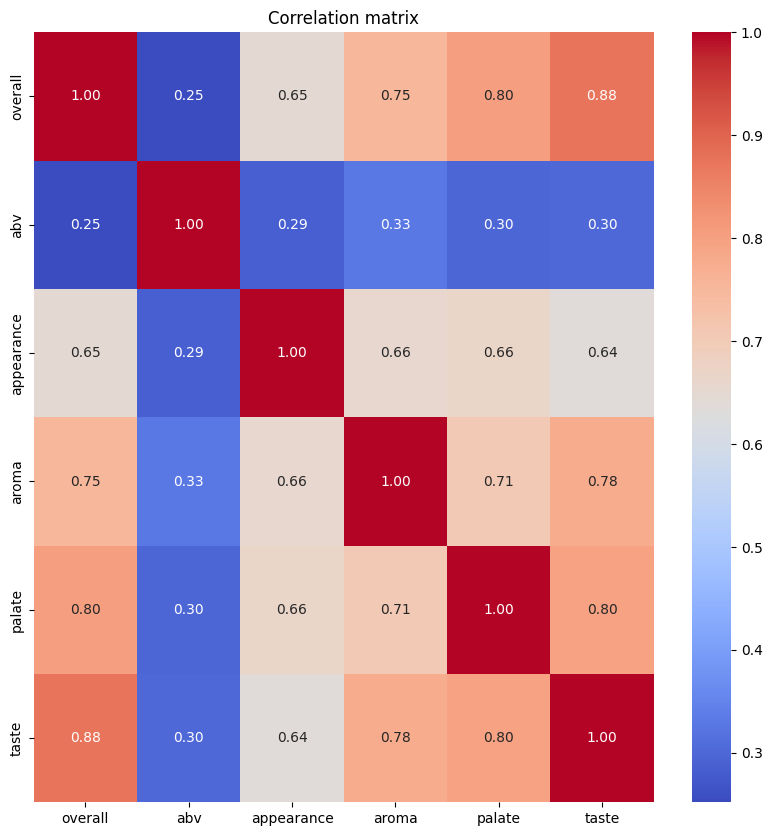

In [4]:
# Plot the correlation label between the 
labels_study_correlation = ["overall", "abv", "appearance", "aroma", "palate", "taste"]
df_ratings_no_text[labels_study_correlation].corr()

# Plot the correlation matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(df_ratings_no_text[labels_study_correlation].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

In [5]:
import geopandas as gpd
from matplotlib import colors as mcolors

def plot_country(df, column, title, normalize=False):
    world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
    merged = world.merge(df, how='left', left_on='name', right_on='location')

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 10))
    world.plot(ax=ax, color='lightgray')  

    # Plot with log scale normalization
    merged.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap='viridis',  
        norm=mcolors.LogNorm(vmin=merged[column].min(), vmax=merged[column].max()) if normalize else None,
        missing_kwds={"color": "lightgray"}
    )
    ax.set_title(title)
    plt.axis('off')
    plt.show()

countries_to_filter = df_ratings_no_text.groupby('location').agg({'user_id': 'count'}).reset_index()
countries_to_filter = countries_to_filter.rename(columns={'user_id': 'count'})
countries_to_filter = countries_to_filter[countries_to_filter['count'] > 100]
countries_to_filter_list = countries_to_filter['location'].to_list()
df_ratings_no_text_filtered = df_ratings_no_text[df_ratings_no_text['location'].isin(countries_to_filter_list)]

In [ ]:
# Compute the average of the beer ratings


### Location analysis

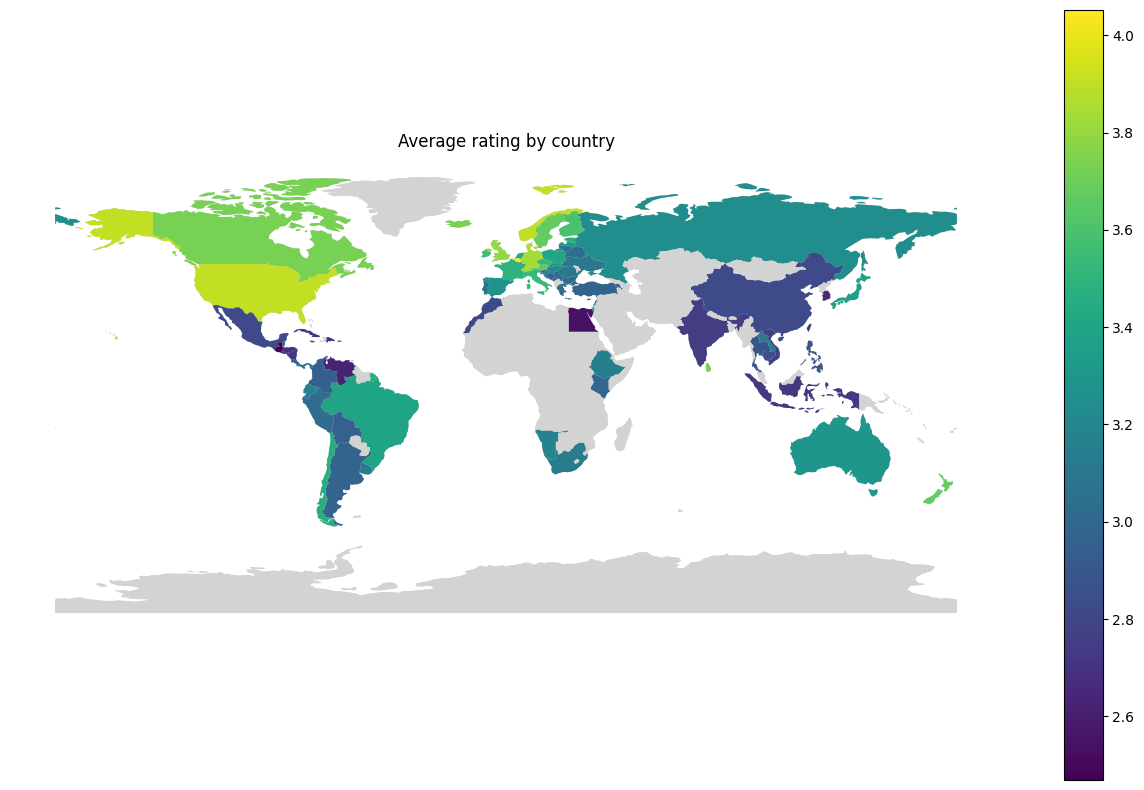

In [6]:
# Plot the average rating by country
df_ratings_no_text_filtered_country = df_ratings_no_text_filtered.groupby('location').agg({'rating': 'mean'}).reset_index()
plot_country(df_ratings_no_text_filtered_country, 'rating', 'Average rating by country')

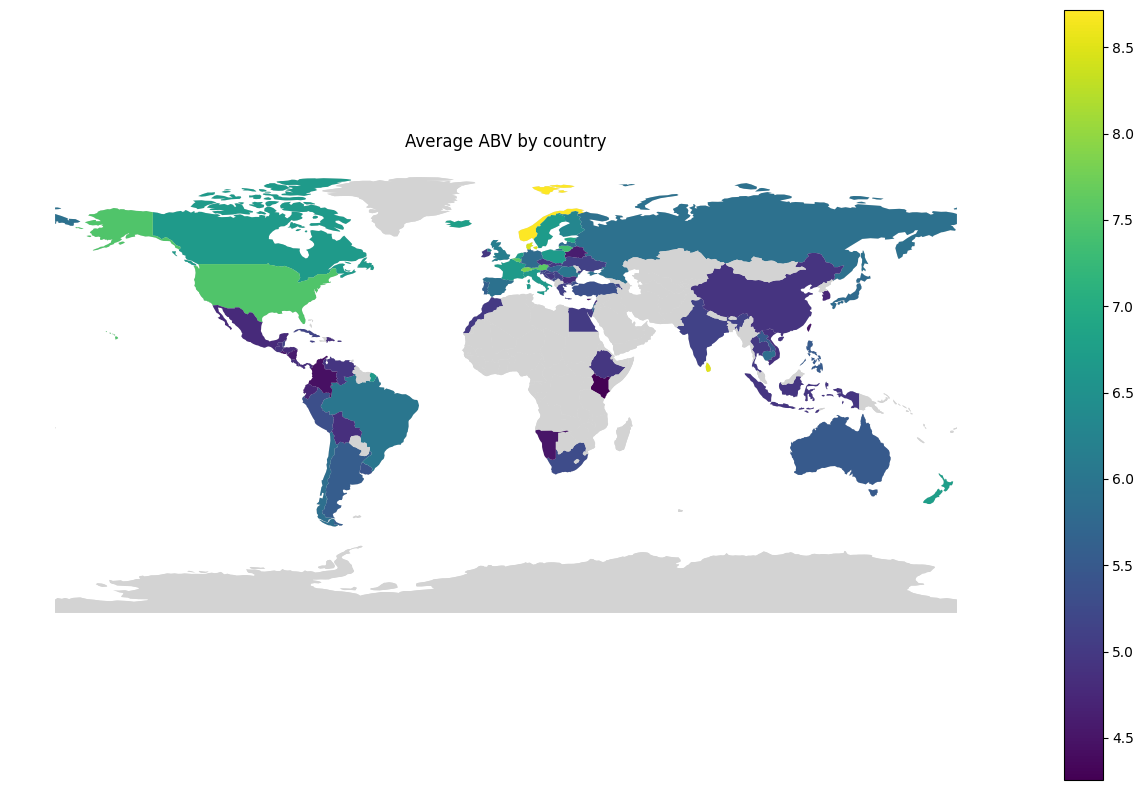

In [7]:
# Plot the average abv by country
average_abv_by_country = df_ratings_no_text_filtered.groupby('location').agg({'abv': 'mean'}).reset_index()
plot_country(average_abv_by_country, 'abv', 'Average ABV by country')

<Axes: xlabel='location'>

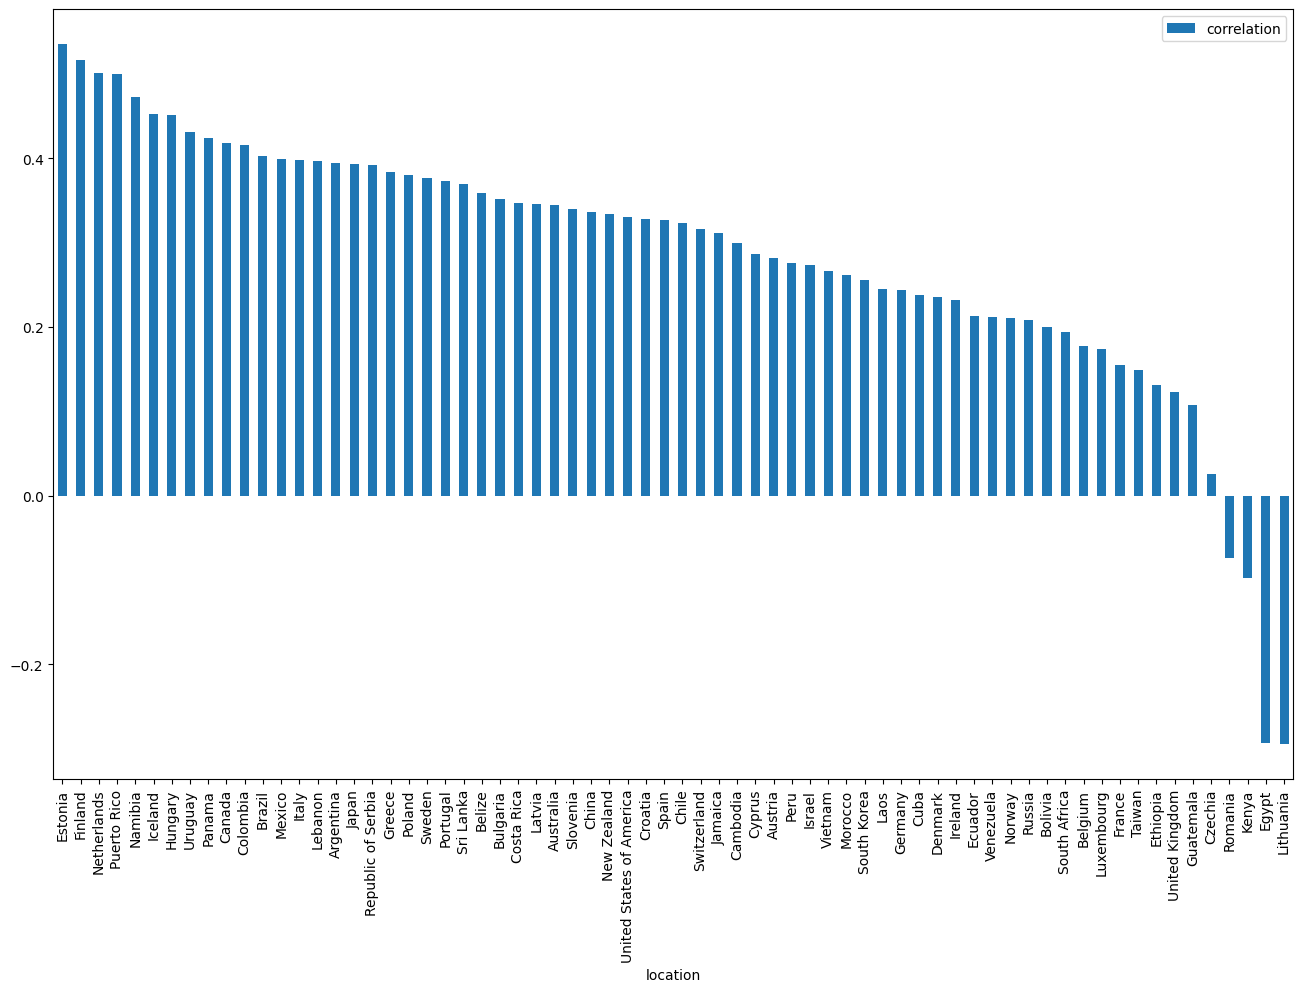

In [12]:
from scipy.stats import pearsonr

df_ratings_no_text_filtered = df_ratings_no_text_filtered.dropna(subset=['abv'])

corr_per_country = {}
condifence = 0.05
for country in countries_to_filter_list:
    p_correration = pearsonr(df_ratings_no_text_filtered[df_ratings_no_text_filtered['location'] == country]['abv'], df_ratings_no_text_filtered[df_ratings_no_text_filtered['location'] == country]['rating'])
    if p_correration[1] < condifence:
        corr_per_country[country] = p_correration[0]

df_corr_per_country = pd.DataFrame(corr_per_country.items(), columns=['location', 'correlation'])
df_corr_per_country = df_corr_per_country.sort_values(by='correlation', ascending=False)
df_corr_per_country.plot.bar(x='location', y='correlation', figsize=(16, 10))

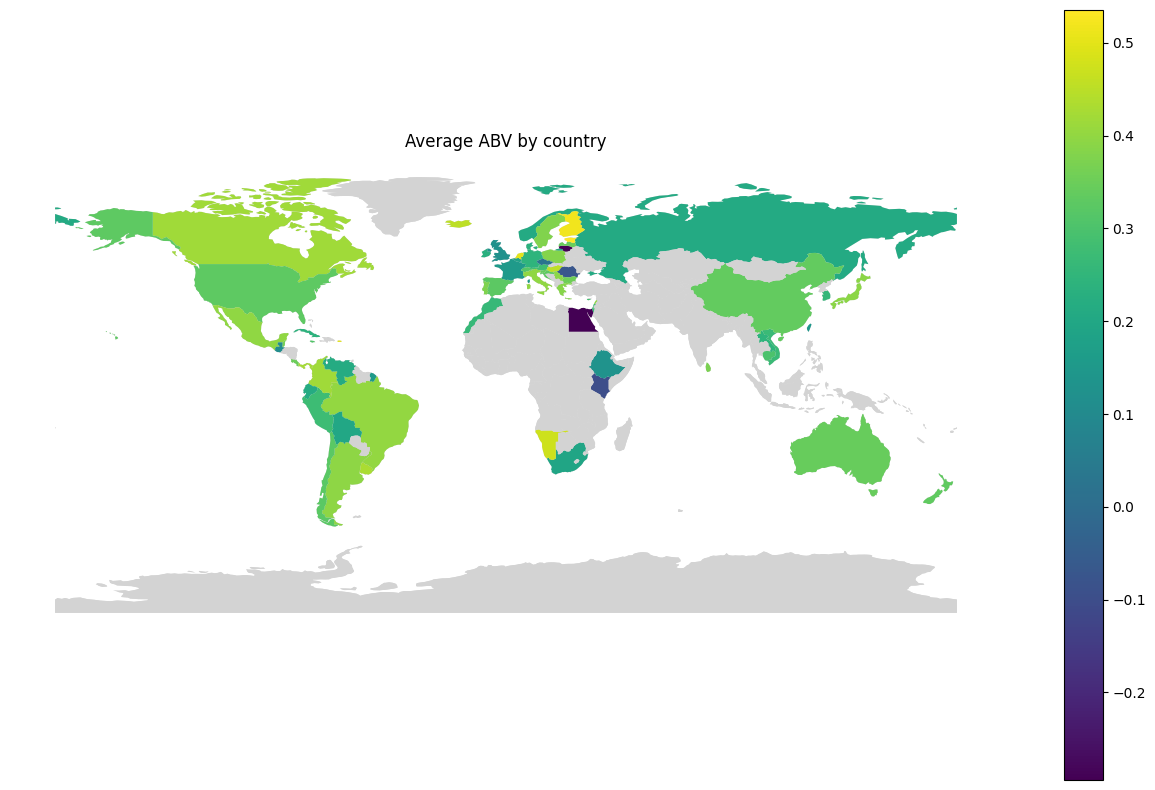

In [14]:
plot_country(df_corr_per_country, 'correlation', 'Average ABV by country')

In [24]:
religion = pd.read_csv('data/WRP_national.csv')
religion = religion[religion['year'] == 2010]
# Understand how to unify the data with the countries https://correlatesofwar.org/data-sets/world-religion-data/